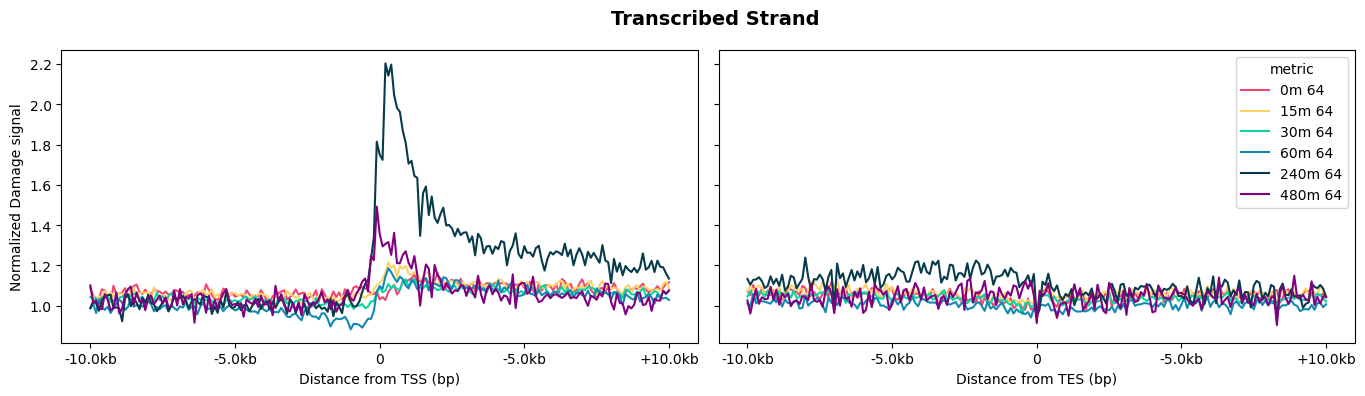

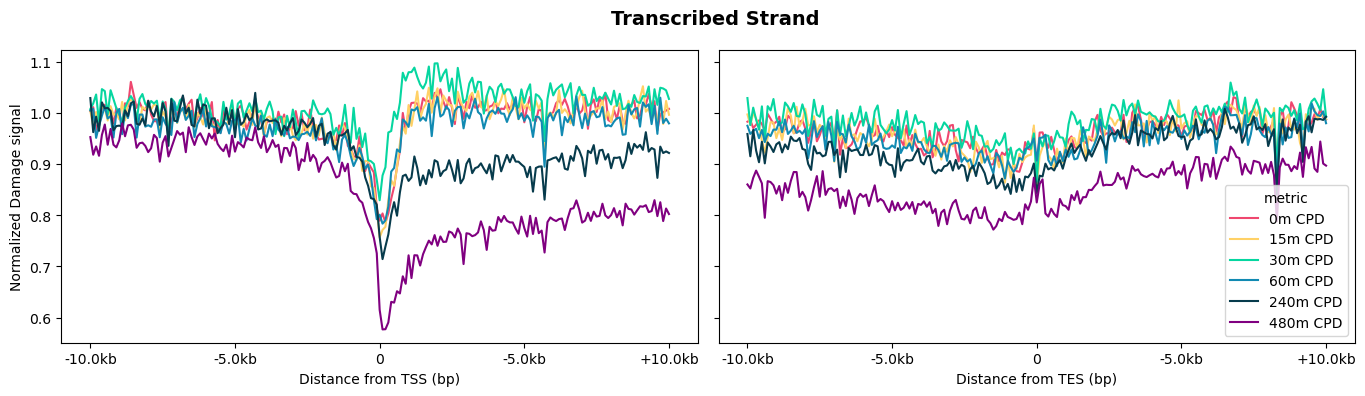

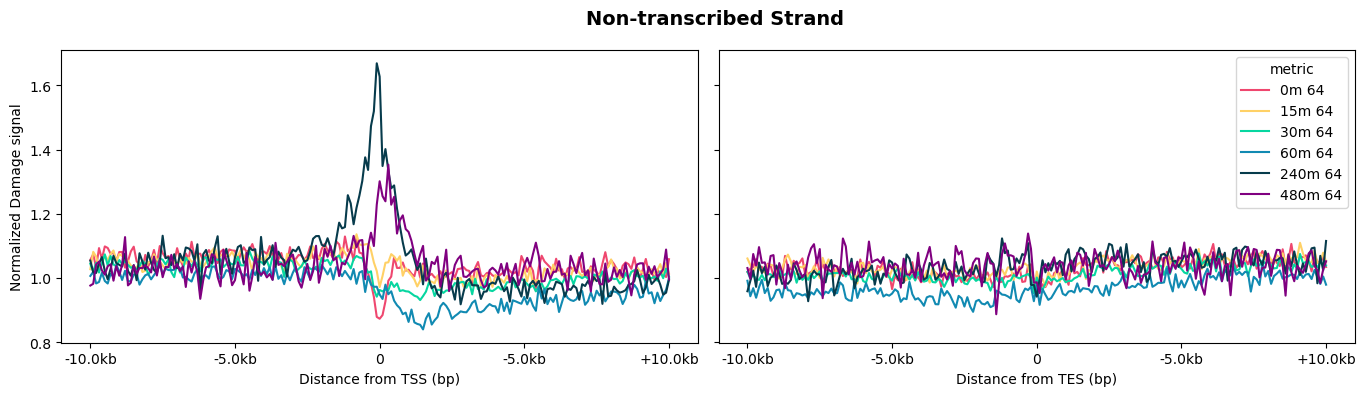

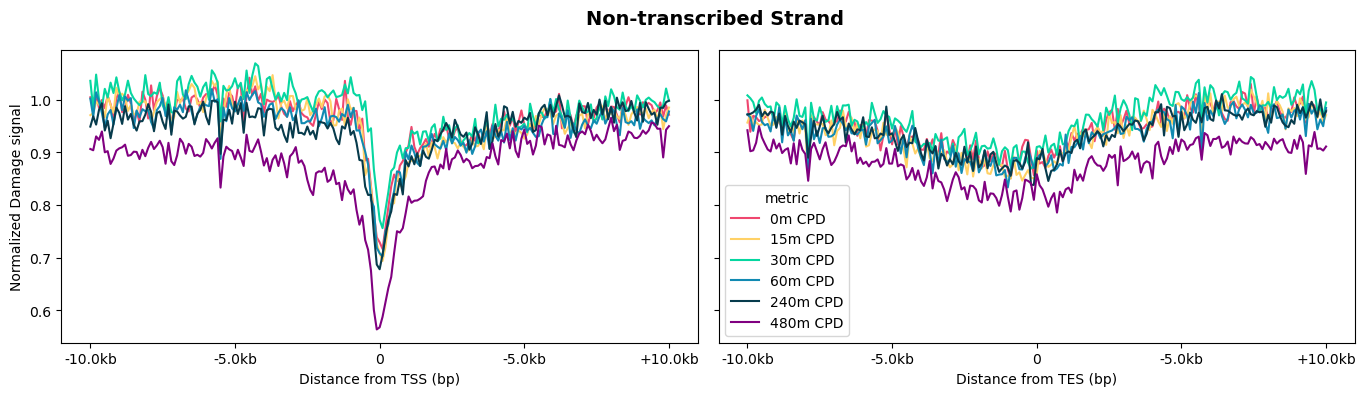

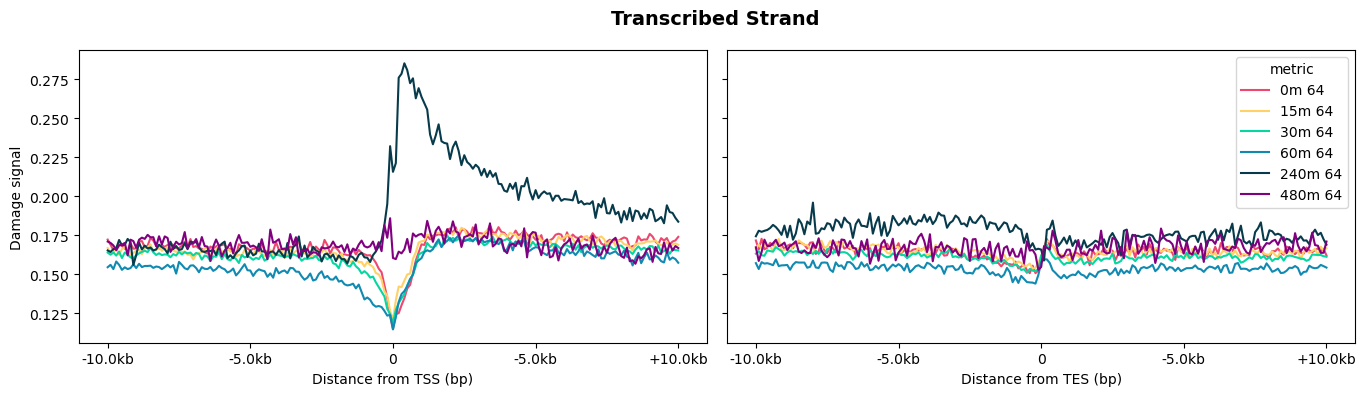

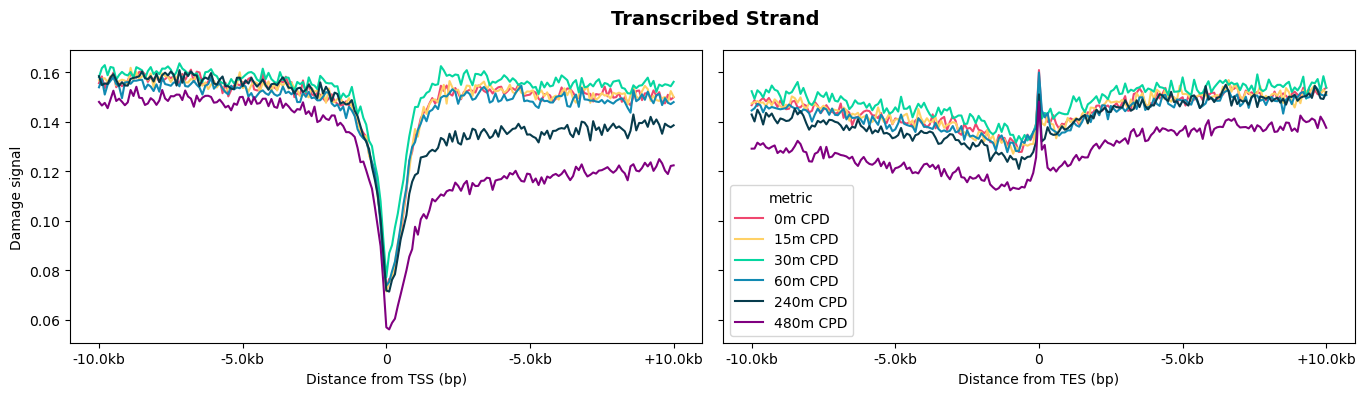

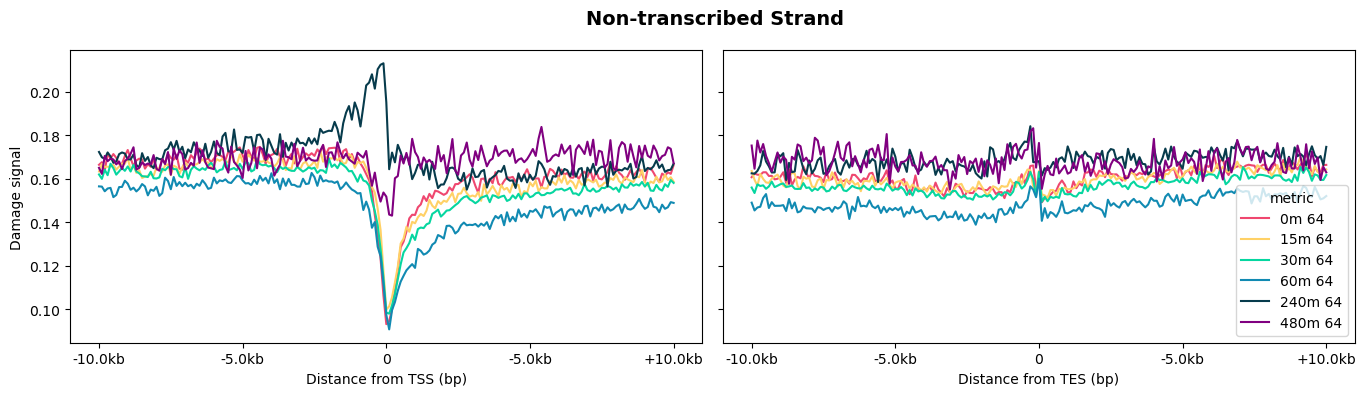

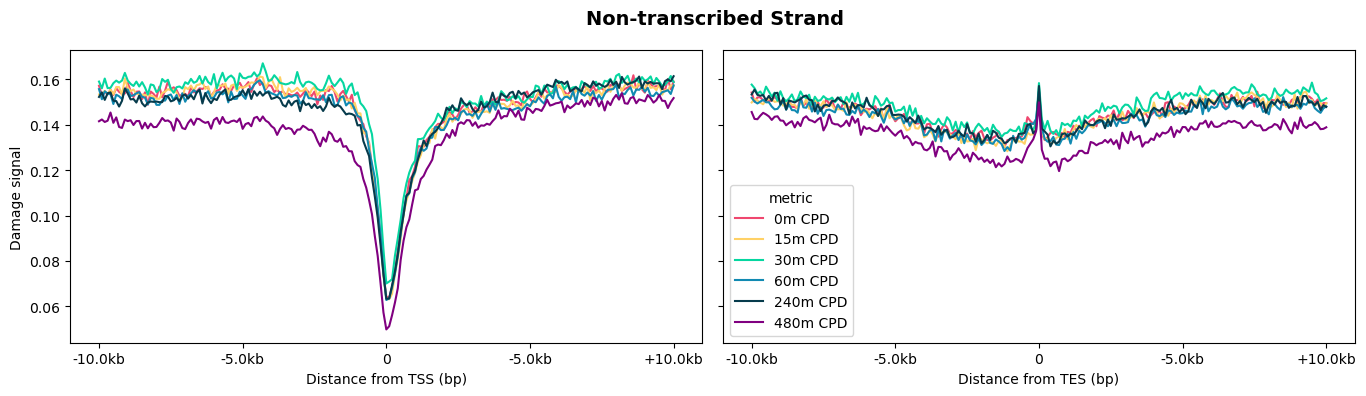

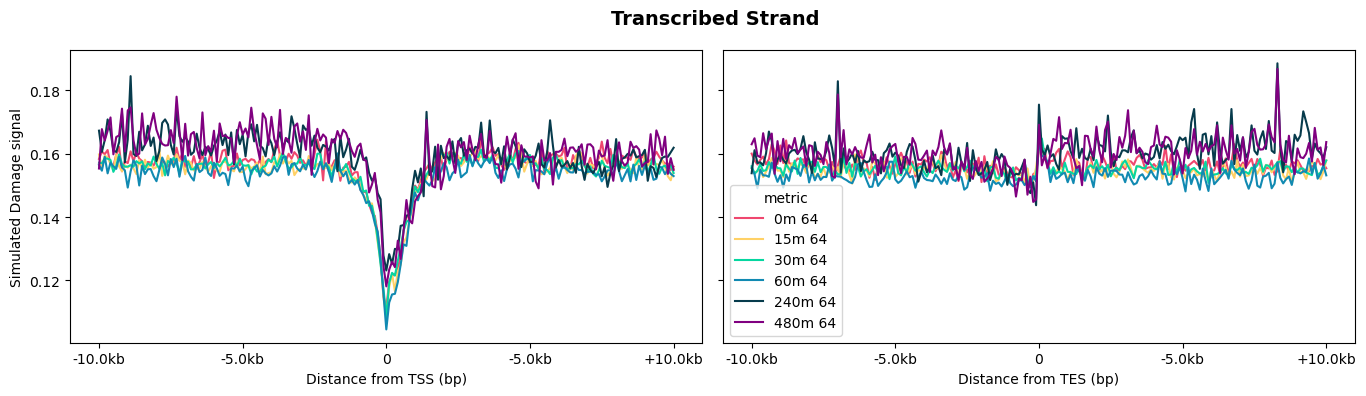

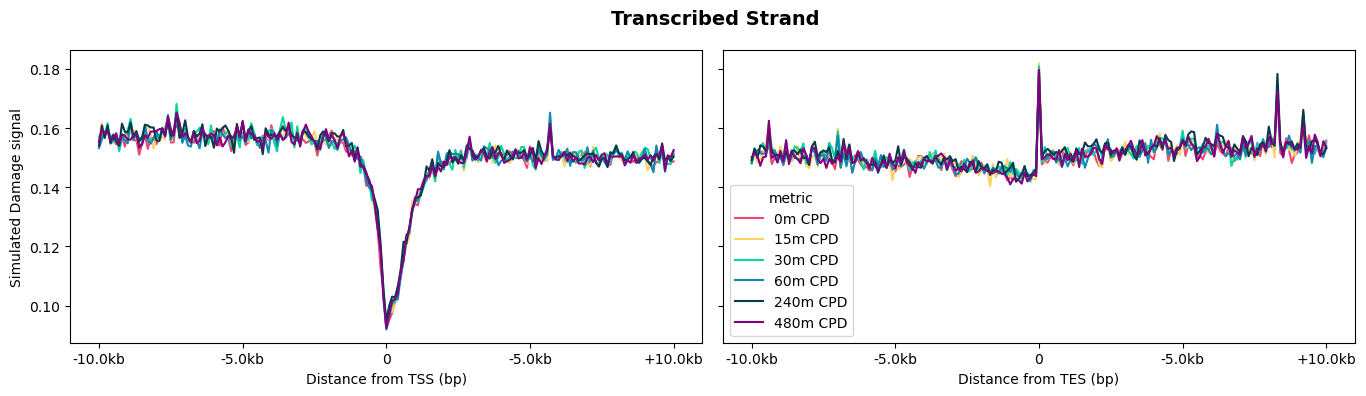

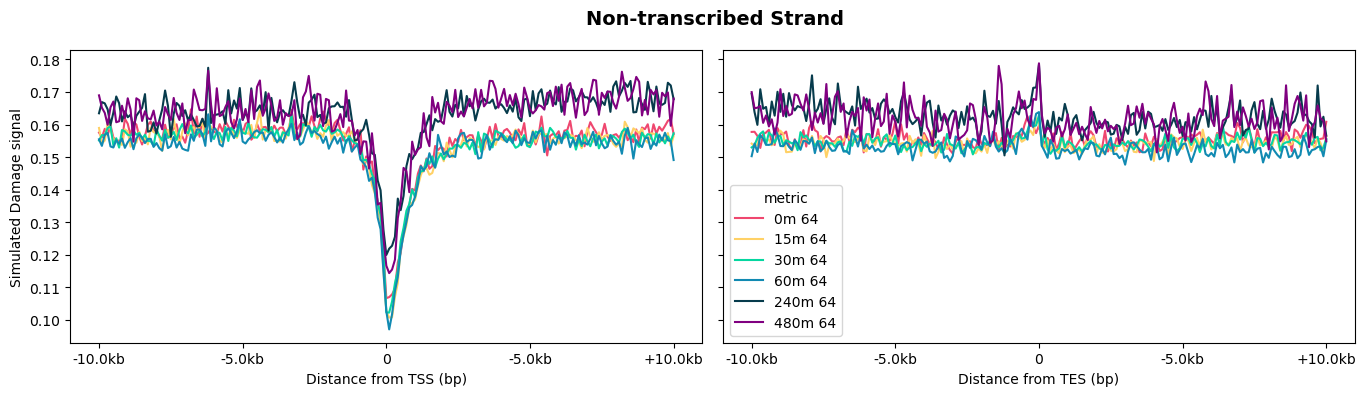

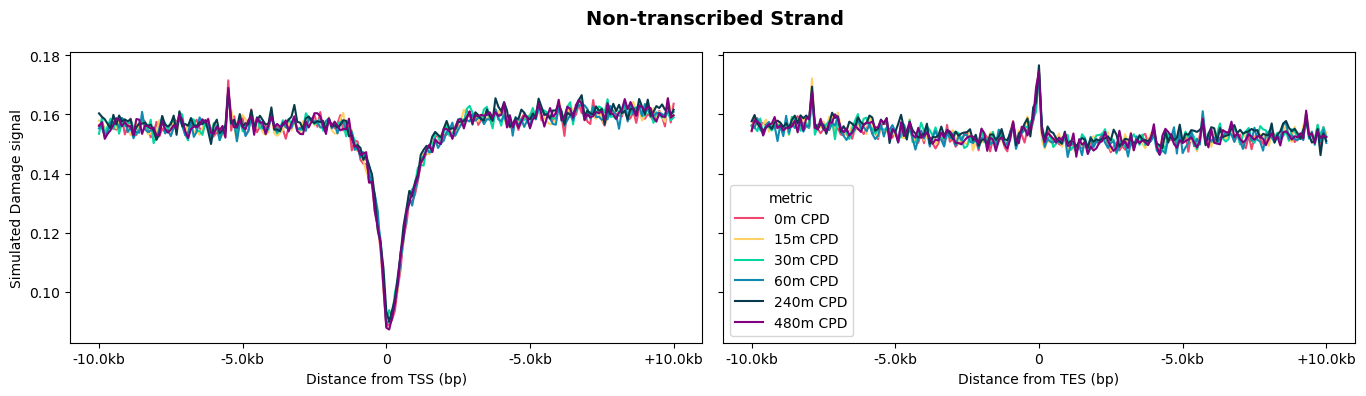

In [84]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

metric_rename = {

    'HD64_0_rep3_norm': '0m 64',
    'HD64_15_rep1_norm': '15m 64',
    'HD64_30_rep2_norm': '30m 64',
    'HD64_60_rep2_norm': '60m 64',
    'HD64_240_rep1_norm': '240m 64',
    'HD64_480_rep1_norm': '480m 64',
    'HDC_0_rep3_norm': '0m CPD',
    'HDC_15_rep1_norm': '15m CPD',
    'HDC_30_rep2_norm': '30m CPD',
    'HDC_60_rep2_norm': '60m CPD',
    'HDC_240_rep1_norm': '240m CPD',
    'HDC_480_rep1_norm': '480m CPD',

    # 'HD64_0_rep1_norm': '0m 64 (2022 rep1)',
    # 'HD64_0_rep2_norm': '0m 64 (2022 rep2)',
    # 'HDC_0_rep1_norm': '0m CPD (2022 rep1)',
    # 'HDC_0_rep2_norm': '0m CPD (2022 rep2)',
    # 'HX64_12_rep1_norm': '12m 64 XR (2022 rep1)',
    # 'HX64_12_rep2_norm': '12m 64 XR (2022 rep2)',
    # 'HXC_12_rep1_norm': '12m CPD XR (2022 rep1)',
    # 'HXC_12_rep2_norm': '12m CPD XR (2022 rep2)',
}

metric_color = {
    '0m 64': '#ef476f',
    '15m 64': '#ffd166',
    '30m 64': '#06d6a0',
    '60m 64': '#118ab2',
    '240m 64': '#073b4c',
    '480m 64': 'purple',
    '0m CPD': '#ef476f',
    '15m CPD': '#ffd166',
    '30m CPD': '#06d6a0',
    '60m CPD': '#118ab2',
    '240m CPD': '#073b4c',
    '480m CPD': 'purple',
}

legend_order_2025_64 = ['0m 64', '15m 64', '30m 64', '60m 64', '240m 64', '480m 64']
legend_order_2025_CPD = ['0m CPD', '15m CPD', '30m CPD', '60m CPD', '240m CPD', '480m CPD']

df = pd.read_csv("results/master/tss_201_100/mapped_all.csv", index_col=None)

df['ori'] = (df['strand'] == df['dam_strand']).map({True: 'NTS', False: 'TS'})

def plot_cosmetics(df):
    win_num = df["window"].max()
    interval_length = df.iloc[0]["end"] - df.iloc[0]["start"]
    boundary = win_num * interval_length / 1000
    p_ticks = [df["window"].min(),df["window"].min()/2,df["window"].median(),df["window"].max()/2,df["window"].max()]
    p_ticklabs = [f"-{boundary}kb",f"-{boundary/2:.1f}kb",0,f"-{boundary/2:.1f}kb",f"+{boundary}kb"]

    return p_ticks, p_ticklabs

p_ticks, p_ticklabs = plot_cosmetics(df)


df_tss = df[(df['name'].str.contains('tss'))]
df_tes = df[(df['name'].str.contains('tes'))]

df_tss_agg = df_tss[target_list].groupby(["ori", "window"]).mean(numeric_only=True).reset_index()
df_tes_agg = df_tes[target_list].groupby(["ori", "window"]).mean(numeric_only=True).reset_index()

df_tss_agg_real = df_tss_agg.copy()
df_tes_agg_real = df_tes_agg.copy()
df_tss_agg_sim = df_tss_agg.copy()
df_tes_agg_sim = df_tes_agg.copy()

for column in list(df_tss.columns[df_tss.columns.str.startswith('H') & ~df_tss.columns.str.contains('sim')]):
    df_tss_agg[f"{column}_norm"] = df_tss_agg[column] / df_tss_agg[f"{column}_sim"]
    df_tss_agg_real[f"{column}_norm"] = df_tss_agg_real[column]
    df_tss_agg_sim[f"{column}_norm"] = df_tss_agg_sim[f"{column}_sim"]

    df_tss_agg_real.drop(columns=[column, f"{column}_sim"], inplace=True)
    df_tss_agg_sim.drop(columns=[column, f"{column}_sim"], inplace=True)
    df_tss_agg.drop(columns=[column, f"{column}_sim"], inplace=True)

for column in list(df_tes.columns[df_tes.columns.str.startswith('H') & ~df_tes.columns.str.contains('sim')]):
    df_tes_agg[f"{column}_norm"] = df_tes_agg[column] / df_tes_agg[f"{column}_sim"]
    df_tes_agg_real[f"{column}_norm"] = df_tes_agg_real[column]
    df_tes_agg_sim[f"{column}_norm"] = df_tes_agg_sim[f"{column}_sim"]

    df_tes_agg_real.drop(columns=[column, f"{column}_sim"], inplace=True)
    df_tes_agg_sim.drop(columns=[column, f"{column}_sim"], inplace=True)
    df_tes_agg.drop(columns=[column, f"{column}_sim"], inplace=True)


def melt_and_rename(df):
    df_melted = pd.melt(df, id_vars=['ori', 'window'], var_name='metric', value_name='value')
    df_melted['metric'] = df_melted['metric'].map(metric_rename)
    df_melted = df_melted[~df_melted["metric"].isna()]
    return df_melted

df_tss_melted = melt_and_rename(df_tss_agg)
df_tes_melted = melt_and_rename(df_tes_agg)
df_tss_real_melted = melt_and_rename(df_tss_agg_real)
df_tes_real_melted = melt_and_rename(df_tes_agg_real)
df_tss_sim_melted = melt_and_rename(df_tss_agg_sim)
df_tes_sim_melted = melt_and_rename(df_tes_agg_sim)


def plot_tss_damage(df_tss_melted, df_tes_melted, damage, ori, signal):

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    if ori == 'TS':
        title = 'Transcribed Strand'
    else:
        title = 'Non-transcribed Strand'

    if damage == '64':
        legend_order = legend_order_2025_64
    else:
        legend_order = legend_order_2025_CPD


    fig.suptitle(title, fontsize=14, fontweight='bold', x=0.45)

    # Plot TSS
    sns.lineplot(data=df_tss_melted[(df_tss_melted['metric'].str.contains(damage)) & (df_tss_melted['ori'] == ori)], 
                x='window', y='value', hue='metric', hue_order=legend_order, palette=metric_color, ax=ax1)
    ax1.set_xlabel('Distance from TSS (bp)')
    ax1.set_ylabel(signal)
    ax1.legend_.remove()  # Remove individual legend
    ax1.set_xticks(p_ticks)
    ax1.set_xticklabels(p_ticklabs)


    # Plot TES
    sns.lineplot(data=df_tes_melted[(df_tes_melted['metric'].str.contains(damage)) & (df_tes_melted['ori'] == ori)], 
                x='window', y='value', hue='metric', hue_order=legend_order, palette=metric_color, ax=ax2)
    ax2.set_xlabel('Distance from TES (bp)')
    ax2.set_ylabel(signal)
    # ax2.legend_.remove()  # Remove individual legend
    ax2.set_xticks(p_ticks)
    ax2.set_xticklabels(p_ticklabs)

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Make room for the legend

    plt.show()

plot_tss_damage(df_tss_melted, df_tes_melted, '64', 'TS', 'Normalized Damage signal')
plot_tss_damage(df_tss_melted, df_tes_melted, 'CPD', 'TS', 'Normalized Damage signal')
plot_tss_damage(df_tss_melted, df_tes_melted, '64', 'NTS', 'Normalized Damage signal')
plot_tss_damage(df_tss_melted, df_tes_melted, 'CPD', 'NTS', 'Normalized Damage signal')

plot_tss_damage(df_tss_real_melted, df_tes_real_melted, '64', 'TS', 'Damage signal')
plot_tss_damage(df_tss_real_melted, df_tes_real_melted, 'CPD', 'TS', 'Damage signal')
plot_tss_damage(df_tss_real_melted, df_tes_real_melted, '64', 'NTS', 'Damage signal')
plot_tss_damage(df_tss_real_melted, df_tes_real_melted, 'CPD', 'NTS', 'Damage signal')

plot_tss_damage(df_tss_sim_melted, df_tes_sim_melted, '64', 'TS', 'Simulated Damage signal')
plot_tss_damage(df_tss_sim_melted, df_tes_sim_melted, 'CPD', 'TS', 'Simulated Damage signal')
plot_tss_damage(df_tss_sim_melted, df_tes_sim_melted, '64', 'NTS', 'Simulated Damage signal')
plot_tss_damage(df_tss_sim_melted, df_tes_sim_melted, 'CPD', 'NTS', 'Simulated Damage signal')

In [83]:
df_tes_agg_real

,ori,window,HX64_12_rep1,HX64_12_rep2,HXC_12_rep1,HXC_12_rep2,HD64_0_rep1,HD64_0_rep2,HDC_0_rep1,HDC_0_rep2,...,HD64_15_rep1,HDC_15_rep1,HD64_30_rep2,HDC_30_rep2,HD64_60_rep2,HDC_60_rep2,HD64_240_rep1,HDC_240_rep1,HD64_480_rep1,HDC_480_rep1
0,NTS,-100,0.219576,0.211986,0.236011,0.233228,0.162132,0.175296,0.159291,0.170824,...,0.163504,0.149758,0.155923,0.157633,0.148959,0.151822,0.162442,0.153282,0.175221,0.145577
1,NTS,-99,0.227343,0.217996,0.231045,0.229352,0.169117,0.174449,0.151545,0.164144,...,0.159476,0.151341,0.153395,0.156092,0.145385,0.150202,0.162276,0.155455,0.164574,0.142535
2,NTS,-98,0.217682,0.208148,0.231792,0.226338,0.162897,0.175126,0.161725,0.162681,...,0.156770,0.150672,0.157356,0.153631,0.146730,0.149331,0.163553,0.153125,0.177509,0.142396
3,NTS,-97,0.221942,0.218899,0.242953,0.233162,0.162846,0.175465,0.158074,0.170570,...,0.162199,0.149692,0.156639,0.154596,0.147088,0.150126,0.166108,0.152716,0.172037,0.143938
4,NTS,-96,0.223195,0.210151,0.235835,0.230379,0.163457,0.173432,0.156912,0.166689,...,0.159879,0.148991,0.156922,0.152774,0.151104,0.150936,0.172716,0.153062,0.175917,0.145216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,TS,96,0.215567,0.208091,0.228496,0.222065,0.168301,0.177612,0.151047,0.162172,...,0.166323,0.154654,0.162456,0.155500,0.153816,0.154390,0.178548,0.154416,0.168654,0.140590
398,TS,97,0.220411,0.216134,0.229947,0.227597,0.162234,0.177895,0.157963,0.167643,...,0.162022,0.152092,0.162369,0.157229,0.154215,0.153136,0.175105,0.152464,0.168256,0.137396
399,TS,98,0.223640,0.210603,0.232539,0.224715,0.170035,0.180437,0.150162,0.161981,...,0.167596,0.151113,0.162315,0.152540,0.155981,0.151043,0.176548,0.149410,0.163679,0.142035
400,TS,99,0.215594,0.207301,0.229200,0.222628,0.154535,0.178234,0.151158,0.165162,...,0.165324,0.152810,0.161523,0.158381,0.155161,0.150569,0.172328,0.149174,0.163778,0.140104


In [1]:
import pandas as pd
df_init = pd.read_csv("results/master/tss_201_100/mapped_all.csv", index_col=None)
df_init.head()

,chrom,start,end,name,score,strand,window,dam_strand,HX64_12_rep1,HX64_12_rep2,...,HD64_15_rep1_sim,HDC_15_rep1_sim,HD64_30_rep2_sim,HDC_30_rep2_sim,HD64_60_rep2_sim,HDC_60_rep2_sim,HD64_240_rep1_sim,HDC_240_rep1_sim,HD64_480_rep1_sim,HDC_480_rep1_sim
0,chr1,55369,55469,tss_1525,.,+,-100,+,0.0,0.0,...,0.320678,0.324898,0.000000,0.000000,0.418498,0.00000,0.000000,0.00000,1.980659,0.000000
1,chr1,55369,55469,tss_1525,.,+,-100,-,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.105488,0.00000,0.000000,0.000000
2,chr1,55469,55569,tss_1525,.,+,-99,+,0.0,0.0,...,0.320678,1.624488,0.864051,0.000000,0.000000,0.00000,0.000000,0.31335,0.000000,0.276501
3,chr1,55469,55569,tss_1525,.,+,-99,-,0.0,0.0,...,0.000000,0.324898,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.553001
4,chr1,55569,55669,tss_1525,.,+,-98,+,0.0,0.0,...,1.924066,0.324898,0.216013,0.310019,0.418498,0.30421,1.105488,0.00000,1.980659,0.553001


In [2]:
df = df_init.copy()

In [3]:
df['ori'] = (df['strand'] == df['dam_strand']).map({True: 'NTS', False: 'TS'})

In [4]:
# df.loc[df["strand"]=="+", "window"] *= -1

In [5]:
target_list = ['ori', 'window'] + list(df.columns[df.columns.str.startswith('H')])

In [6]:
# df_tss = df[(df['name'].str.contains('tss')) & (df['strand']=="+")]
# df_tes = df[(df['name'].str.contains('tes')) & (df['strand']=="+")]
df_tss = df[(df['name'].str.contains('tss'))]
df_tes = df[(df['name'].str.contains('tes'))]


In [39]:
df_tss_agg = df_tss[target_list].groupby(["ori", "window"]).mean(numeric_only=True).reset_index()
df_tes_agg = df_tes[target_list].groupby(["ori", "window"]).mean(numeric_only=True).reset_index()

In [40]:
for column in list(df_tss.columns[df_tss.columns.str.startswith('H') & ~df_tss.columns.str.contains('sim')]):
    # df_tss_agg[f"{column}_norm"] = df_tss_agg[column] / df_tss_agg[f"{column}_sim"]
    df_tss_agg[f"{column}_norm"] = df_tss_agg[column]

    df_tss_agg.drop(columns=[column, f"{column}_sim"], inplace=True)
for column in list(df_tes.columns[df_tes.columns.str.startswith('H') & ~df_tes.columns.str.contains('sim')]):
    # df_tes_agg[f"{column}_norm"] = df_tes_agg[column] / df_tes_agg[f"{column}_sim"]
    df_tes_agg[f"{column}_norm"] = df_tes_agg[column]

    df_tes_agg.drop(columns=[column, f"{column}_sim"], inplace=True)


In [47]:
df_tes.columns

Index(['chrom', 'start', 'end', 'name', 'score', 'strand', 'window',
       'dam_strand', 'HX64_12_rep1', 'HX64_12_rep2', 'HXC_12_rep1',
       'HXC_12_rep2', 'HD64_0_rep1', 'HD64_0_rep2', 'HDC_0_rep1', 'HDC_0_rep2',
       'HD64_0_rep3', 'HDC_0_rep3', 'HD64_15_rep1', 'HDC_15_rep1',
       'HD64_30_rep2', 'HDC_30_rep2', 'HD64_60_rep2', 'HDC_60_rep2',
       'HD64_240_rep1', 'HDC_240_rep1', 'HD64_480_rep1', 'HDC_480_rep1',
       'HX64_12_rep1_sim', 'HX64_12_rep2_sim', 'HXC_12_rep1_sim',
       'HXC_12_rep2_sim', 'HD64_0_rep1_sim', 'HD64_0_rep2_sim',
       'HDC_0_rep1_sim', 'HDC_0_rep2_sim', 'HD64_0_rep3_sim', 'HDC_0_rep3_sim',
       'HD64_15_rep1_sim', 'HDC_15_rep1_sim', 'HD64_30_rep2_sim',
       'HDC_30_rep2_sim', 'HD64_60_rep2_sim', 'HDC_60_rep2_sim',
       'HD64_240_rep1_sim', 'HDC_240_rep1_sim', 'HD64_480_rep1_sim',
       'HDC_480_rep1_sim', 'ori'],
      dtype='object')

In [55]:

df_tss_melted = pd.melt(df_tss_agg, id_vars=['ori', 'window'], var_name='metric', value_name='value')
df_tes_melted = pd.melt(df_tes_agg, id_vars=['ori', 'window'], var_name='metric', value_name='value')

metric_rename = {

    'HD64_0_rep3_norm': '0m 64',
    'HD64_15_rep1_norm': '15m 64',
    'HD64_30_rep2_norm': '30m 64',
    'HD64_60_rep2_norm': '60m 64',
    'HD64_240_rep1_norm': '240m 64',
    'HD64_480_rep1_norm': '480m 64',
    'HDC_0_rep3_norm': '0m CPD',
    'HDC_15_rep1_norm': '15m CPD',
    'HDC_30_rep2_norm': '30m CPD',
    'HDC_60_rep2_norm': '60m CPD',
    'HDC_240_rep1_norm': '240m CPD',
    'HDC_480_rep1_norm': '480m CPD',

    # 'HD64_0_rep1_norm': '0m 64 (2022 rep1)',
    # 'HD64_0_rep2_norm': '0m 64 (2022 rep2)',
    # 'HDC_0_rep1_norm': '0m CPD (2022 rep1)',
    # 'HDC_0_rep2_norm': '0m CPD (2022 rep2)',
    # 'HX64_12_rep1_norm': '12m 64 XR (2022 rep1)',
    # 'HX64_12_rep2_norm': '12m 64 XR (2022 rep2)',
    # 'HXC_12_rep1_norm': '12m CPD XR (2022 rep1)',
    # 'HXC_12_rep2_norm': '12m CPD XR (2022 rep2)',
}

metric_color = {
    '0m 64': '#ef476f',
    '15m 64': '#ffd166',
    '30m 64': '#06d6a0',
    '60m 64': '#118ab2',
    '240m 64': '#073b4c',
    '480m 64': 'purple',
    '0m CPD': '#ef476f',
    '15m CPD': '#ffd166',
    '30m CPD': '#06d6a0',
    '60m CPD': '#118ab2',
    '240m CPD': '#073b4c',
    '480m CPD': 'purple',
}

legend_order_2025_64 = ['0m 64', '15m 64', '30m 64', '60m 64', '240m 64', '480m 64']
legend_order_2025_CPD = ['0m CPD', '15m CPD', '30m CPD', '60m CPD', '240m CPD', '480m CPD']

In [56]:
df_tss_melted['metric'] = df_tss_melted['metric'].map(metric_rename)
df_tes_melted['metric'] = df_tes_melted['metric'].map(metric_rename)

In [57]:
df_tss_melted = df_tss_melted[~df_tss_melted["metric"].isna()]
df_tes_melted = df_tes_melted[~df_tes_melted["metric"].isna()]

In [58]:
def plot_cosmetics(df):
    win_num = df["window"].max()
    interval_length = df.iloc[0]["end"] - df.iloc[0]["start"]
    boundary = win_num * interval_length / 1000
    p_ticks = [df["window"].min(),df["window"].min()/2,df["window"].median(),df["window"].max()/2,df["window"].max()]
    p_ticklabs = [f"-{boundary}kb",f"-{boundary/2:.1f}kb",0,f"-{boundary/2:.1f}kb",f"+{boundary}kb"]

    return p_ticks, p_ticklabs

p_ticks, p_ticklabs = plot_cosmetics(df)

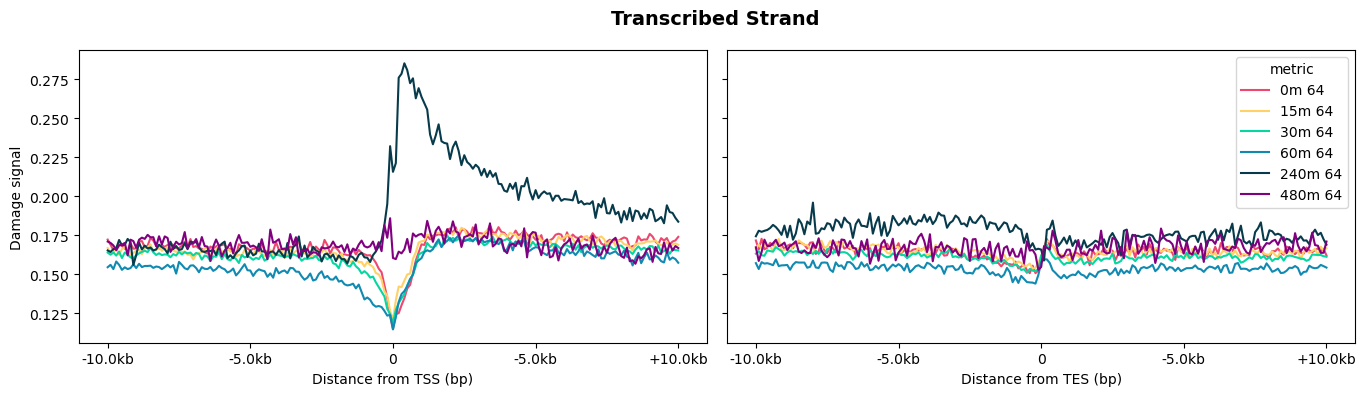

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

fig.suptitle('Transcribed Strand', fontsize=14, fontweight='bold', x=0.45)

# Plot TSS
sns.lineplot(data=df_tss_melted[(df_tss_melted['metric'].str.contains('64')) & (df_tss_melted['ori'] == 'TS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_64, palette=metric_color, ax=ax1)
ax1.set_xlabel('Distance from TSS (bp)')
ax1.set_ylabel('Damage signal')
ax1.legend_.remove()  # Remove individual legend
ax1.set_xticks(p_ticks)
ax1.set_xticklabels(p_ticklabs)


# Plot TES
sns.lineplot(data=df_tes_melted[(df_tes_melted['metric'].str.contains('64')) & (df_tes_melted['ori'] == 'TS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_64, palette=metric_color, ax=ax2)
ax2.set_xlabel('Distance from TES (bp)')
ax2.set_ylabel('Damage signal')
# ax2.legend_.remove()  # Remove individual legend
ax2.set_xticks(p_ticks)
ax2.set_xticklabels(p_ticklabs)

# Add a single legend for both plots
# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='center right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for the legend

plt.show()

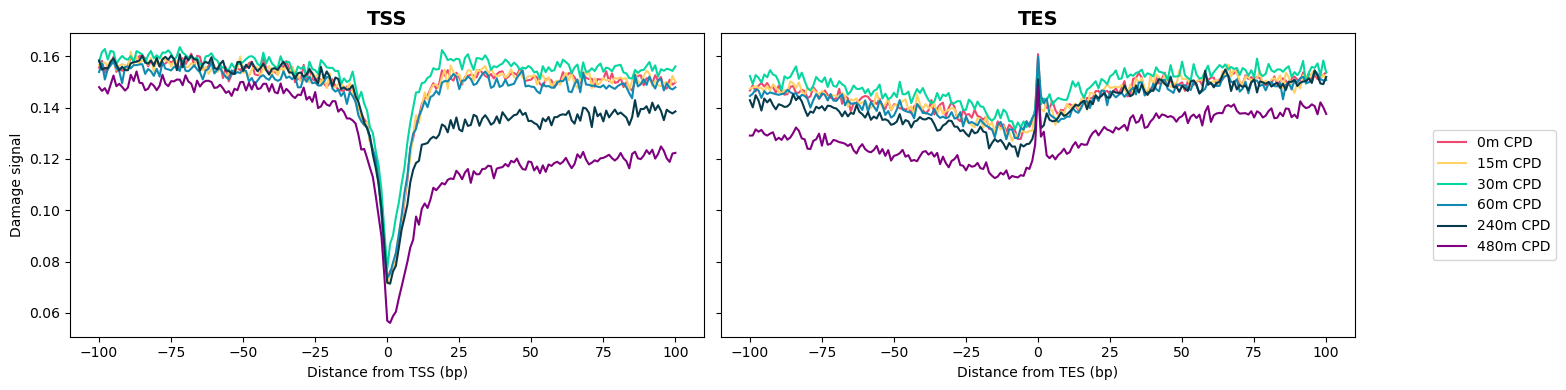

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# Plot TSS
sns.lineplot(data=df_tss_melted[(df_tss_melted['metric'].str.contains('CPD')) & (df_tss_melted['ori'] == 'TS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_CPD, palette=metric_color, ax=ax1)
ax1.set_title('TSS', fontsize=14, fontweight='bold')
ax1.set_xlabel('Distance from TSS (bp)')
ax1.set_ylabel('Damage signal')
ax1.legend_.remove()  # Remove individual legend

# Plot TES
sns.lineplot(data=df_tes_melted[(df_tes_melted['metric'].str.contains('CPD')) & (df_tes_melted['ori'] == 'TS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_CPD, palette=metric_color, ax=ax2)
ax2.set_title('TES', fontsize=14, fontweight='bold')
ax2.set_xlabel('Distance from TES (bp)')
ax2.set_ylabel('Damage signal')
ax2.legend_.remove()  # Remove individual legend

# Add a single legend for both plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for the legend

plt.show()

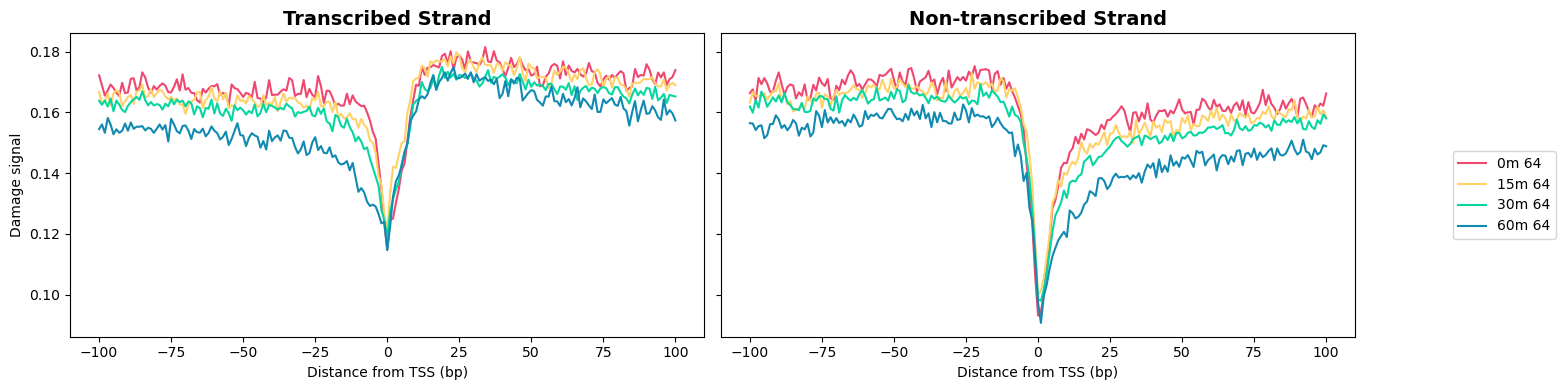

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# Plot TS (Transcribed Strand)
sns.lineplot(data=df_tss_melted[(df_tss_melted['metric'].str.contains('64')) & (df_tss_melted['ori'] == 'TS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_64, palette=metric_color, ax=ax1)
ax1.set_title('Transcribed Strand', fontsize=14, fontweight='bold')
ax1.set_xlabel('Distance from TSS (bp)')
ax1.set_ylabel('Damage signal')
ax1.legend_.remove()  # Remove individual legend

# Plot NTS (Non-transcribed Strand)
sns.lineplot(data=df_tss_melted[(df_tss_melted['metric'].str.contains('64')) & (df_tss_melted['ori'] == 'NTS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_64, palette=metric_color, ax=ax2)
ax2.set_title('Non-transcribed Strand', fontsize=14, fontweight='bold')
ax2.set_xlabel('Distance from TSS (bp)')
ax2.set_ylabel('Damage signal')
ax2.legend_.remove()  # Remove individual legend

# Add a single legend for both plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for the legend

plt.show()

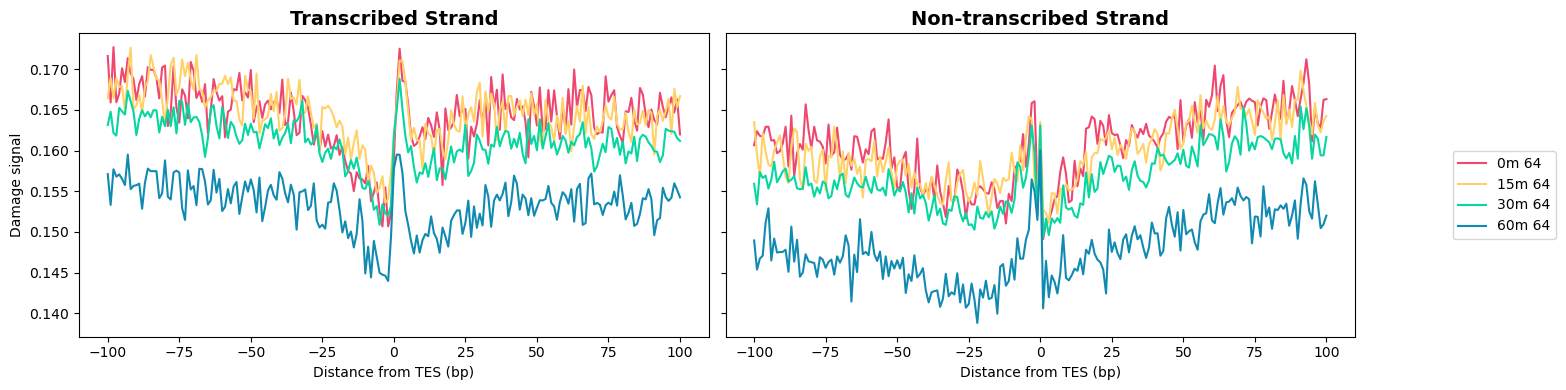

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# Plot TS (Transcribed Strand)
sns.lineplot(data=df_tes_melted[(df_tss_melted['metric'].str.contains('64')) & (df_tes_melted['ori'] == 'TS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_64, palette=metric_color, ax=ax1)
ax1.set_title('Transcribed Strand', fontsize=14, fontweight='bold')
ax1.set_xlabel('Distance from TES (bp)')
ax1.set_ylabel('Damage signal')
ax1.legend_.remove()  # Remove individual legend

# Plot NTS (Non-transcribed Strand)
sns.lineplot(data=df_tes_melted[(df_tss_melted['metric'].str.contains('64')) &(df_tes_melted['ori'] == 'NTS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_64, palette=metric_color, ax=ax2)
ax2.set_title('Non-transcribed Strand', fontsize=14, fontweight='bold')
ax2.set_xlabel('Distance from TES (bp)')
ax2.set_ylabel('Damage signal')
ax2.legend_.remove()  # Remove individual legend

# Add a single legend for both plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for the legend

plt.show()

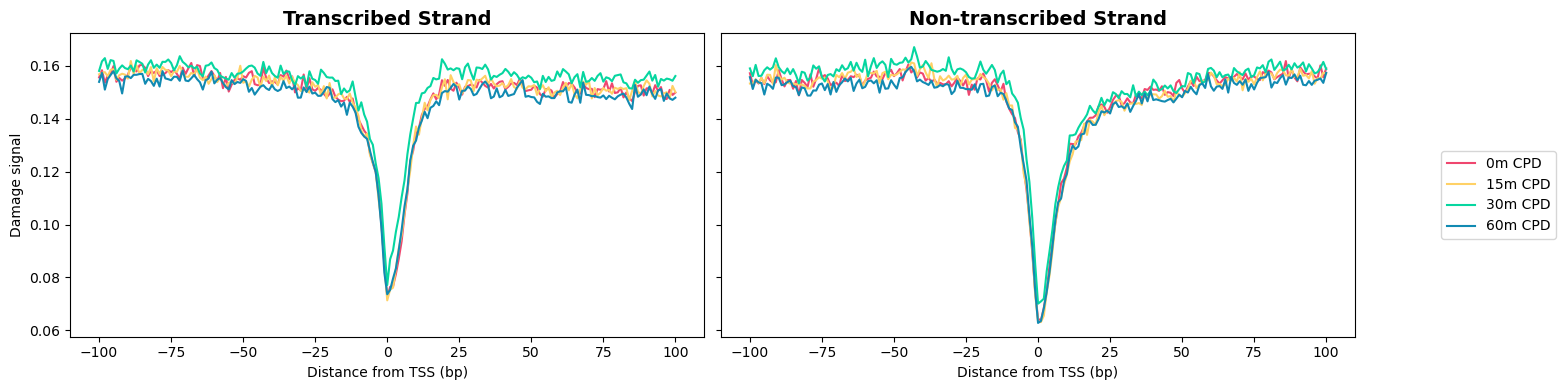

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# Plot TS (Transcribed Strand)
sns.lineplot(data=df_tss_melted[(df_tss_melted['metric'].str.contains('CPD')) & (df_tss_melted['ori'] == 'TS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_CPD, palette=metric_color, ax=ax1)
ax1.set_title('Transcribed Strand', fontsize=14, fontweight='bold')
ax1.set_xlabel('Distance from TSS (bp)')
ax1.set_ylabel('Damage signal')
ax1.legend_.remove()  # Remove individual legend

# Plot NTS (Non-transcribed Strand)
sns.lineplot(data=df_tss_melted[(df_tss_melted['metric'].str.contains('CPD')) & (df_tss_melted['ori'] == 'NTS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_CPD, palette=metric_color, ax=ax2)
ax2.set_title('Non-transcribed Strand', fontsize=14, fontweight='bold')
ax2.set_xlabel('Distance from TSS (bp)')
ax2.set_ylabel('Damage signal')
ax2.legend_.remove()  # Remove individual legend

# Add a single legend for both plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for the legend

plt.show()

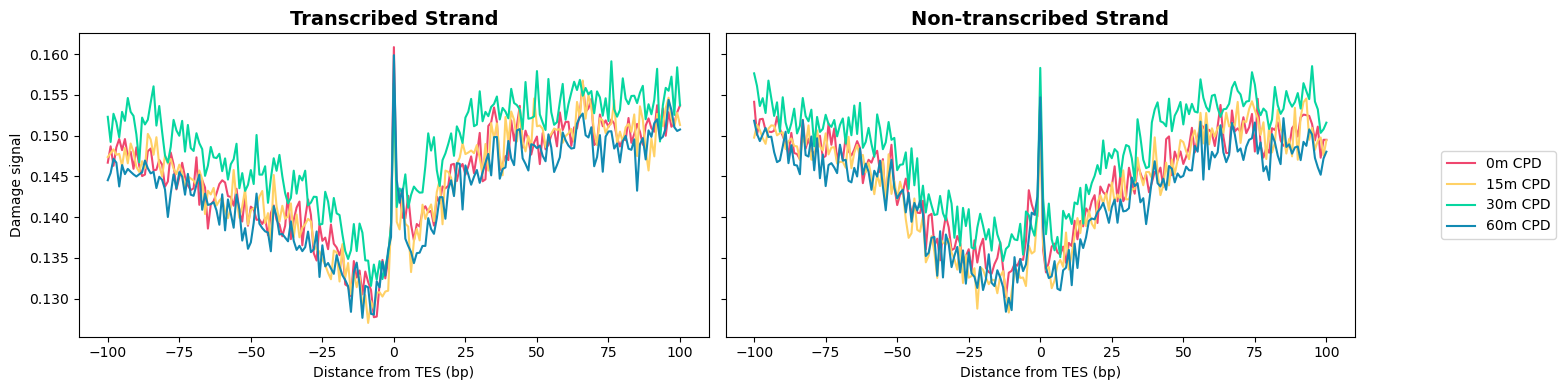

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# Plot TS (Transcribed Strand)
sns.lineplot(data=df_tes_melted[(df_tss_melted['metric'].str.contains('CPD')) & (df_tes_melted['ori'] == 'TS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_CPD, palette=metric_color, ax=ax1)
ax1.set_title('Transcribed Strand', fontsize=14, fontweight='bold')
ax1.set_xlabel('Distance from TES (bp)')
ax1.set_ylabel('Damage signal')
ax1.legend_.remove()  # Remove individual legend

# Plot NTS (Non-transcribed Strand)
sns.lineplot(data=df_tes_melted[(df_tss_melted['metric'].str.contains('CPD')) &(df_tes_melted['ori'] == 'NTS')], 
             x='window', y='value', hue='metric', hue_order=legend_order_2025_CPD, palette=metric_color, ax=ax2)
ax2.set_title('Non-transcribed Strand', fontsize=14, fontweight='bold')
ax2.set_xlabel('Distance from TES (bp)')
ax2.set_ylabel('Damage signal')
ax2.legend_.remove()  # Remove individual legend

# Add a single legend for both plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for the legend

plt.show()